In [1]:
%env XLA_FLAGS=--xla_gpu_force_compilation_parallelism=1

env: XLA_FLAGS=--xla_gpu_force_compilation_parallelism=1


## Generate datasets

In [2]:
import numpy as onp
import jax.numpy as jnp


def synthetic_mode_classification(T, n, C, r):
  """Generate a distribtuion over Gaussian Mixture models.
  
  Args:
    T: int, number of GMM distributions.
    n: number of points per GMM.
    C: maximum number of modes per GMM.
    r: int, input dimension.

  Returns:
    (T, n, 2) array of points and (T, n) array of labels.
  """
  x, y = [], []
  for t in range(T):
    p = onp.random.randint(1, C+1)
    Mu = onp.random.uniform(low=-5., high=5., size=(p, r))
    A = onp.random.uniform(low=-1., high=1., size=(p, r, r))
    a = onp.random.uniform(low=1., high=4., size=(p,))
    B = onp.random.uniform(low=0, high=1., size=(p, r))
    Sigma = onp.einsum('p,pik,pjk->pij', a, A, A) + onp.stack([onp.diag(b) for b in B])
    ns = onp.random.multinomial(n, onp.ones(p) / p)
    gaussians = [onp.random.multivariate_normal(m, s, size=ni) for m, s, ni in zip(Mu, Sigma, ns)]
    sample = onp.concatenate(gaussians, axis=0)
    x.append(sample)
    y.append(p)
  x = onp.stack(x, axis=0)
  y = onp.stack(y, axis=0)
  return x, y


In [3]:
import itertools as it
from functools import reduce
import operator
from tqdm import tqdm
import os

def generate_all_GMM(overwrite=False):
  r_range = [2, 10]
  C_range = [2, 10]
  T_range = [16, 32, 64, 128, 256, 512, 1024, 2048]
  n_range = [16, 32, 64, 128, 256, 512, 1024, 2048]
  fold_range = list(range(5))
  all_ranges = [r_range, C_range, T_range, n_range, fold_range]
  total = reduce(operator.mul, (len(r) for r in all_ranges), 1)

  for r, C, T, n, fold in tqdm(it.product(*all_ranges), total=total):
    filename = f'../../data/data_{T}_{n}_{C}_{r}_{fold}.npz'
    if not overwrite and os.path.exists(filename):
      continue
    x, y = synthetic_mode_classification(T, n, C, r)
    onp.savez(filename, x=x, y=y)

In [4]:
generate_all_GMM(overwrite=False)

100%|██████████| 1280/1280 [00:00<00:00, 215870.89it/s]


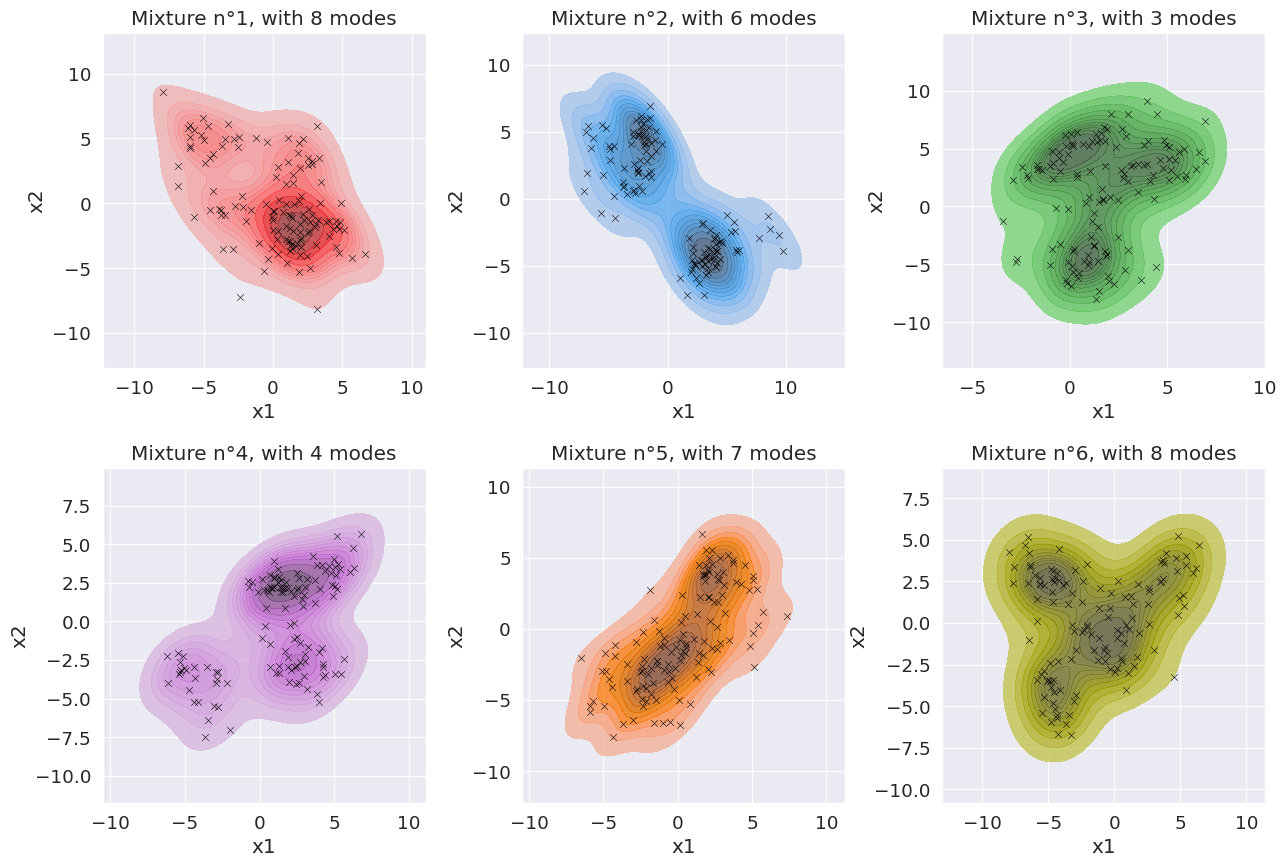

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set(context='paper', font_scale=1.5)
npz_file = onp.load('../../data/data_256_128_10_2_0.npz')
x, y = npz_file['x'], npz_file['y']
# x is of shape (128, 128, 2)
# plot points + density contours
# for 4 GMM indexed by i
# four jointplot in figures axes

num_rows, num_cols = 2, 3
axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5))[1].flatten()
plt.subplots_adjust(wspace=0.3, hspace=0.3)
gmm_to_plot = num_rows * num_cols
label = sum([[i]*x.shape[1] for i, label in enumerate(y[:gmm_to_plot])], [])
hue = 'Mixture n°'
df = pd.DataFrame.from_dict({'x1':x[:gmm_to_plot,:,0].flatten(), 'x2':x[:gmm_to_plot,:,1].flatten(), hue:label})
palette = sns.color_palette('Set1', n_colors=gmm_to_plot)
for i, (ax, label, color) in enumerate(zip(axes, y[:gmm_to_plot], palette)):
  df_i = df[df[hue] == i]
  title = f"{hue}{i+1}, with {label} modes"
  ax = sns.kdeplot(data=df_i, x='x1', y='x2', fill=True, color=color, levels=12, alpha=0.8, ax=ax, legend=False, thresh=0.05)
  ax = sns.scatterplot(data=df_i, x='x1', y='x2', color='black', marker='x', ax=ax)
  ax.set_title(title)
plt.savefig('mixtures.png', dpi=300, bbox_inches='tight')

## Sliced-Wasserstein embeddings

In [6]:
import numpy as np


def random_projections(n_projections, dim, seed=None):
  """Generate random projection vectors.
  
  Args:
    n_projections: integer, number of projection vectors
    dim: integer, dimension of the ambient space
    seed: integer, random seed
  
  Returns:
    (n_projections, dim) array of projection vectors
  """
  np.random.seed(seed)
  theta = np.random.randn(n_projections, dim)
  theta = theta / np.linalg.norm(theta, axis=1, keepdims=True)
  return theta


def deterministic_projections(n_projections, dim, seed=None):
  """Generate random projection vectors.
  
  Args:
    n_projections: integer, number of projection vectors
    dim: integer, dimension of the ambient space
    seed: integer, random seed
  
  Returns:
    (n_projections, dim) array of projection vectors
  """
  assert dim == 2, "Only implemented for dim=2"
  angles = np.linspace(-np.pi, np.pi, n_projections)
  theta = np.array([np.cos(angles), np.sin(angles)]).T
  return theta, angles


def sliced_wasserstein_embeddings(point_cloud, projections, t):
  """Sliced Wasserstein features from projections.
  
  Args:
    point_cloud: WeightedPoint cloud of shape (n, dim)
    projections: (n_projections, dim) array of projection vectors
    t: integer, number of points used in integration of CDF.

  Returns:
    (n, n_projections * T) array of Sliced Wasserstein features
  """
  # shape (n, k), (n,)
  point, weights = point_cloud
  points = point @ projections.T  # shape (n, n_projections)
  cum_t = np.linspace(0, 1, t)  # shape (T,)
  weights = weights / np.sum(weights, axis=0, keepdims=True)  # re-normalize weights
  inv_cdf = []
  for proj in range(projections.shape[0]):
    points_slice = np.array(points[:, proj])  # shape (n,)
    points_idx = np.argsort(points_slice, axis=0, kind='mergesort')
    points_slice = np.take_along_axis(points_slice, points_idx, axis=0)  # sort points
    weights_slice = np.take_along_axis(weights, points_idx, axis=0)  # sort weights
    cum_cdf_slice = np.cumsum(weights_slice)  # shape (n,)
    inv_cdf_slice = np.interp(cum_t, cum_cdf_slice, points_slice)  # shape (T,)
    inv_cdf.append(inv_cdf_slice)
  inv_cdf = np.array(inv_cdf)  # shape (n_projections, T)
  return inv_cdf


def hilbertian_sliced(distributions):
  """Compute the Hilbertian embedding associated to Sliced Wasserstein kernel.

  Args:
    distributions: array of shape (num_distribution, points_per_distribution, dim)
    
  Returns:
    array of shape (num_distribution, num_projections * num_points)
  """
  n_discrete, n_projections = 10, 10
  projections = random_projections(n_projections, distributions.shape[2])
  hilbertian = []
  for points in distributions:
    point_cloud = (points, np.ones(points.shape[0]))
    embeddings = sliced_wasserstein_embeddings(point_cloud, projections, n_discrete)
    embeddings = embeddings.flatten()
    embeddings = embeddings / np.sqrt(n_projections * n_discrete)
    hilbertian.append(embeddings)
  hilbertian = np.stack(hilbertian)
  return hilbertian


## Sinkhorn kernel

In [7]:
from flax import struct
from dataclasses import replace
from functools import partial
import jax
import jax.numpy as jnp
from ott.geometry.pointcloud import PointCloud
from ott.problems.linear.linear_problem import LinearProblem
from ott.solvers.linear.sinkhorn import Sinkhorn


@struct.dataclass
class WeightedPointCloud:
  """A weighted point cloud.
  
  Attributes:
    cloud: Array of shape (n, d) where n is the number of points and d the dimension.
    weights: Array of shape (n,) where n is the number of points.
  """
  cloud: jnp.array
  weights: jnp.array

  def __len__(self):
    return self.cloud.shape[0]


@struct.dataclass
class VectorizedWeightedPointCloud:
  """Vectorized version of WeightedPointCloud.

  Assume that b clouds are all of size n and dimension d.
  
  Attributes:
    clouds: Array of shape (b, n, d) where n is the number of points and d the dimension.
    weights: Array of shape (b, n) where n is the number of points.
  
  Methods:
    unpack: returns the cloud and weights.
  """
  clouds: jnp.array
  weights: jnp.array

  def __getitem__(self, idx):
    return WeightedPointCloud(self.clouds[idx], self.weights[idx])
  
  def __len__(self):
    return self.clouds.shape[0]
  
  def __iter__(self):
    for i in range(len(self)):
      yield self[i]

  def unpack(self):
    return self.clouds, self.weights

  @property
  def dim(self):
    return self.clouds.shape[-1]


def clouds_barycenter(points):
  """Compute the barycenter of a set of clouds.
  
  Args:
    points: a VectorizedWeightedPointCloud.
    
  Returns:
    a barycenter of the clouds of points, of shape (1, d) where d is the dimension.
  """
  clouds, weights = points.unpack()
  barycenter = jnp.sum(clouds * weights[:,:,jnp.newaxis], axis=1)
  barycenter = jnp.mean(barycenter, axis=0, keepdims=True)
  return barycenter


def to_simplex(mu):
  """Project weights to the simplex.
  
  Args: 
    mu: a WeightedPointCloud.
    
  Returns:
    a WeightedPointCloud with weights projected to the simplex."""
  if mu.weights is None:
    mu_weights = None
  else:
    mu_weights = jax.nn.softmax(mu.weights)
  return replace(mu, weights=mu_weights)


def reparametrize_mu(mu, cloud_barycenter, scale):
  """Re-parametrize mu to be invariant by translation and scaling.

  Args:
    mu: a WeightedPointCloud.
    cloud_barycenter: Array of shape (1, d) where d is the dimension.
    scale: float, scaling parameter for the re-parametrization of mu.
  
  Returns:
    a WeightedPointCloud with re-parametrized weights and cloud.
  """
  # invariance by translation : recenter mu around its mean
  mu_cloud = mu.cloud - jnp.mean(mu.cloud, axis=0, keepdims=True)  # center.
  mu_cloud = scale * jnp.tanh(mu_cloud)  # re-parametrization of the domain.
  mu_cloud = mu_cloud + cloud_barycenter  # re-center toward barycenter of all clouds.
  return replace(mu, cloud=mu_cloud)


def clouds_to_dual_sinkhorn(points, mu, 
                            has_aux=False,
                            sinkhorn_solver_kwargs=None):
  """Compute the embeddings of the clouds with regularized OT towards mu.
  
  Args:
    points: a VectorizedWeightedPointCloud.
    has_aux: bool, whether to return the full Sinkhorn output or only the dual variables.
    sinkhorn_solver_kwargs: dict, kwargs for the Sinkhorn solver.
      Must contain the key 'epsilon' for the regularization parameter.

  Returns:
    the dual variables of the regularized OT problem between points and mu.
  """
  sinkhorn_epsilon = sinkhorn_solver_kwargs.pop('epsilon')

  def sinkhorn_single_cloud(cloud, weights):
    geom = PointCloud(cloud, mu.cloud,
                      epsilon=sinkhorn_epsilon)
    ot_prob = LinearProblem(geom,
                            weights,
                            mu.weights)
    solver = Sinkhorn(**sinkhorn_solver_kwargs)
    ot = solver(ot_prob)
    return ot

  parallel_sinkhorn = jax.vmap(sinkhorn_single_cloud,
                               in_axes=(0, 0),
                               out_axes=0)
  
  outs = parallel_sinkhorn(*points.unpack())

  if has_aux:
    return outs.g, outs
  return outs.g


def mu_uniform(sample_train,
               key,
               mu_size,
               domain='ball',
               radius=1.):
  """Sample mu from a uniform ball of radius radius around the barycenter of the clouds.
  
  Args:
    sample_train: a VectorizedWeightedPointCloud.
    key: a jax.random.PRNGKey.
    mu_size: int, number of points in mu.
    domain: str, domain of the uniform distribution. Can be 'ball' or 'sphere'.
    radius: float, radius of the uniform distribution.
    with_weight: bool, whether to return weights or not.
  
  Returns:
    a WeightedPointCloud.
  """
  dim = sample_train.dim
  key_theta, key_r = jax.random.split(key)
  mu_cloud = jax.random.normal(key_theta, shape=(mu_size, dim))
  norms = jnp.sqrt(jnp.sum(mu_cloud**2, axis=1, keepdims=True))
  mu_cloud = mu_cloud / norms
  if domain == 'ball':
    radii = jax.random.uniform(key_r, shape=(mu_size, 1))
  else:
    radii = jnp.ones((mu_size, 1))
  mu_cloud = mu_cloud * radius * radii
  centroids = jnp.mean(sample_train.clouds, axis=1)
  centroids_center = jnp.mean(centroids, axis=0, keepdims=True)
  mu_cloud = mu_cloud + centroids_center  # OT is invariant by translation for square euclidian cost
  mu_weight = None
  mu_weight = jnp.ones(len(mu_cloud))
  return WeightedPointCloud(mu_cloud, mu_weight)


def mu_GMM_prior(sample_train,
                 key,
                 mu_size):
  dim = sample_train.dim
  key_theta, key_r = jax.random.split(key)
  mu_cloud = jax.random.uniform(key=key_theta, shape=(mu_size, dim), minval=-5., maxval=5.)
  mu_weight = jnp.ones(len(mu_cloud)) / len(mu_cloud)
  return WeightedPointCloud(mu_cloud, mu_weight)


def hilbertian_sinkhorn(points):
  """Compute the embeddings of the clouds with regularized OT towards mu.
  
  Args:
    distributions: array of shape (num_distribution, points_per_distribution, dim)
    
  Returns:
    embeddings of shape (num_distribution, mu_size)
  """
  key = jax.random.PRNGKey(0)
  mu_size = 100
  weights = jnp.ones((points.shape[0], points.shape[1])) / points.shape[1]
  sample_train = VectorizedWeightedPointCloud(points, weights)
  mu = mu_GMM_prior(sample_train, key, mu_size)
  sinkhorn_solver_kwargs = {'epsilon': 0.1, 'max_iterations': 1000}
  embeddings = clouds_to_dual_sinkhorn(sample_train, mu, sinkhorn_solver_kwargs=sinkhorn_solver_kwargs)
  embeddings = onp.array(embeddings)
  return embeddings

## MMD mean embedding

In [8]:
def hilbertian_mean(points):
  mean_embedding = onp.mean(points, axis=1)  # simplest (linear) embedding
  return mean_embedding

## Evaluate Hilbertian embeddings

In [9]:
def get_hilbertian_method(name):
  if name == 'sinkhorn':
    return hilbertian_sinkhorn
  elif name == 'mean':
    return hilbertian_mean
  elif name == 'sliced':
    return hilbertian_sliced
  else:
    raise ValueError(f'Unknown method {name}')

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import explained_variance_score


def scores_from_method(name, standardize=True, overwrite_results=False, overwrite_embeddings=False):
  method = get_hilbertian_method(name)
  
  r_range = [2, 10]
  C_range = [2, 10]
  T_range = [16, 32, 64, 128, 256, 512, 1024, 2048]
  n_range = [16, 32, 64, 128, 256, 512, 1024, 2048]
  fold_range = list(range(5))
  all_ranges = [r_range, C_range, T_range, n_range, fold_range]
  total = reduce(operator.mul, (len(r) for r in all_ranges), 1)

  columns = ['r', 'C', 'T', 'n', 'fold', 'mse', 'evs']

  if os.path.exists(f'{name}_results.csv') and not overwrite_results:
    df = pd.read_csv(f'{name}_results.csv', index_col=0)
  else:
    df = pd.DataFrame(columns=columns)
  
  for r, C, T, n, fold in (pbar := tqdm(it.product(*all_ranges), total=total)):
    # test if [r, C, T, n, fold] is in df
    if len(df[(df['r'] == r) & (df['C'] == C) & (df['T'] == T) & (df['n'] == n) & (df['fold'] == fold)]) > 0:
      if not overwrite_results:
        continue
  
    filename_raw = f'../../data/data_{T}_{n}_{C}_{r}_{fold}.npz'
    filename_embeddings = f'../../data/{name}_{T}_{n}_{C}_{r}_{fold}_embeddings.npz'
    npz_file = onp.load(filename_raw)
    x_train, y_train = npz_file['x'], npz_file['y']

    if os.path.exists(filename_embeddings) and not overwrite_embeddings:
      npz_file = onp.load(filename_embeddings)
      x_train = npz_file['x']
    else:
      x_train = method(x_train)  # embeddings.
      onp.savez(filename_embeddings, x=x_train)
    
    if standardize:
      x_train = (x_train - x_train.mean(axis=0)) / x_train.std(axis=0)
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.5, random_state=42)

    best_mse = onp.inf
    best_evs = 0.
    for alpha_regul in [1e-2, 1e-1, 1, 1e1, 1e2]:
      # ridge regression
      kernel = 'rbf'
      model = KernelRidge(kernel=kernel, alpha=alpha_regul)
      model.fit(x_train, y_train)
      y_pred = model.predict(x_test)
      # regression score (mean square)
      mse = ((y_pred - y_test)**2).mean()
      evs = explained_variance_score(y_test, y_pred)
      best_mse = min(best_mse, mse)
      best_evs = evs if mse == best_mse else best_evs

    pbar.set_description(f'Processing r={r}, C={C}, T={T}, n={n}, fold={fold} with mse={best_mse} evs={evs}')
    df = pd.concat([df, pd.DataFrame([[r, C, T, n, fold, best_mse, best_evs]], columns=columns)])

  df.to_csv(f'{name}_results.csv')
  return df

In [11]:
df = scores_from_method('mean', overwrite_results=False, overwrite_embeddings=False)
df

100%|██████████| 1280/1280 [00:01<00:00, 1018.49it/s]


,r,C,T,n,fold,mse,evs
0,2,2,16,16,0,0.116443,0.536937
0,2,2,16,16,1,1.242029,-0.620295
0,2,2,16,16,2,0.822658,-1.124186
0,2,2,16,16,3,0.579153,-0.672902
0,2,2,16,16,4,0.147052,0.390413
...,...,...,...,...,...,...,...
0,10,10,2048,2048,0,2.630536,0.703560
0,10,10,2048,2048,1,2.852868,0.675039
0,10,10,2048,2048,2,2.919417,0.664213
0,10,10,2048,2048,3,2.878764,0.662266


In [12]:
df[(df['r'] == 2) & (df['C'] == 2)].groupby(['T', 'n']).mean(numeric_only=True).reset_index().pivot(index='T', columns='n', values=['mse', 'evs'])

mse                                                              \
n         16        32        64        128       256       512       1024   
T                                                                            
16    0.581467  0.497741  0.442849  0.447532  0.405262  0.383219  0.431045   
32    0.388006  0.484827  0.344676  0.391561  0.478533  0.340812  0.261150   
64    0.275059  0.291455  0.288409  0.294139  0.288825  0.241425  0.238006   
128   0.256803  0.229593  0.263448  0.226871  0.254587  0.236884  0.249969   
256   0.221629  0.229250  0.226142  0.216164  0.224349  0.211001  0.208608   
512   0.223618  0.223652  0.213811  0.224238  0.220000  0.213613  0.203898   
1024  0.221265  0.211208  0.203230  0.215614  0.209765  0.210342  0.208124   
2048  0.215708  0.214121  0.209131  0.206624  0.208624  0.202940  0.207611   

                     evs                                                    \
n         2048      16        32        64        128       256       512    
T                                                                            
16    0.539990 -0.298007 -0.478763  0.071222 -1.029581 -0.380679 -0.300568   
32    0.306085 -0.266840 -0.450738 -0.202856 -0.223270 -0.267737 -0.130274   
64    0.210767  0.003700 -0.013692 -0.047619 -0.013788  0.041034  0.184004   
128   0.230648 -0.013074  0.118197 -0.026885  0.135007  0.056161  0.071020   
256   0.233003  0.121226  0.089567  0.112677  0.149602  0.111180  0.167995   
512   0.218889  0.116073  0.121099  0.148961  0.104048  0.131367  0.146920   
1024  0.209507  0.115125  0.156080  0.188739  0.140720  0.164102  0.160348   
2048  0.208298  0.137630  0.143147  0.165273  0.175965  0.166509  0.187474   

                          
n         1024      2048  
T                         
16   -0.509437 -0.487004  
32    0.069994 -0.305490  
64    0.120358  0.154635  
128   0.048007  0.119434  
256   0.169443  0.100588  
512   0.184100  0.126095  
1024  0.173589  0.164403  
2048  0.172649  0.170863

In [13]:
def plot_scores(name, metric='evs', shared_x=True, shared_y=False, side_title=False, dpi=100):
  df = pd.read_csv(f'{name}_results.csv', index_col=0)
  sns.set(context='paper', font_scale=1.2)
  r_range = [2, 10]
  C_range = [2, 10]
  num_rows = len(r_range) * len(C_range)
  num_cols = 1
  axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 6))[1].flatten()
  plt.subplots_adjust(hspace=0.05)
  # cmaps = ['inferno', 'viridis', 'plasma', 'magma'][:len(axes)]
  cmaps = ['viridis'] * len(axes)
  for (r, C), ax, cmap in zip(it.product(r_range, C_range), axes, cmaps):
    df_rc = df[(df['r'] == r) & (df['C'] == C)].copy()
    # df_rc['T'] = df_rc['T'] // 2
    df_rc[metric] = df_rc[metric].clip(lower=0)
    grid = df_rc.groupby(['T', 'n']).mean(numeric_only=True)
    grid = grid.reset_index().pivot(index='T', columns='n', values=metric)
    grid = grid.iloc[::-1]
    grid.index = grid.index.rename('Number of Mixtures (n)')
    grid.columns = grid.columns.rename('Points per Mixtures (N)')
    annot = df_rc.groupby(['T', 'n']).std(numeric_only=True).reset_index().pivot(index='T', columns='n', values=metric)
    annot = annot.iloc[::-1]
    annot = annot.applymap(lambda x: f'±\n{x:.2f}')
    sns.heatmap(grid, cmap=cmap, annot=annot, cbar_kws={'label': 'Explained Variance Score'},
                ax=ax, fmt='', vmin=0., vmax=0.8, cbar=False)
    ax.set_xlabel(ax.get_xlabel(), fontsize=16)
    ax.set_ylabel(ax.get_ylabel(), fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
    if shared_x and ax != axes[-1]:
      ax.set_xlabel('')
      ax.set_xticklabels('')
    if shared_y:
      ax.set_ylabel('')
      ax.set_yticklabels('')
    # ax.set_title(f'Dimension={r}, Number of Modes Max={C}', fontweight='bold', loc='left')
    if side_title:
      ax.text(-0.2, 0.5, f'Dimension d={r}, Number of modes C={C}', fontweight='bold', transform=ax.transAxes, rotation=90, va='center')
    plt.savefig(f'{name}_scores_{metric}.png', dpi=dpi)

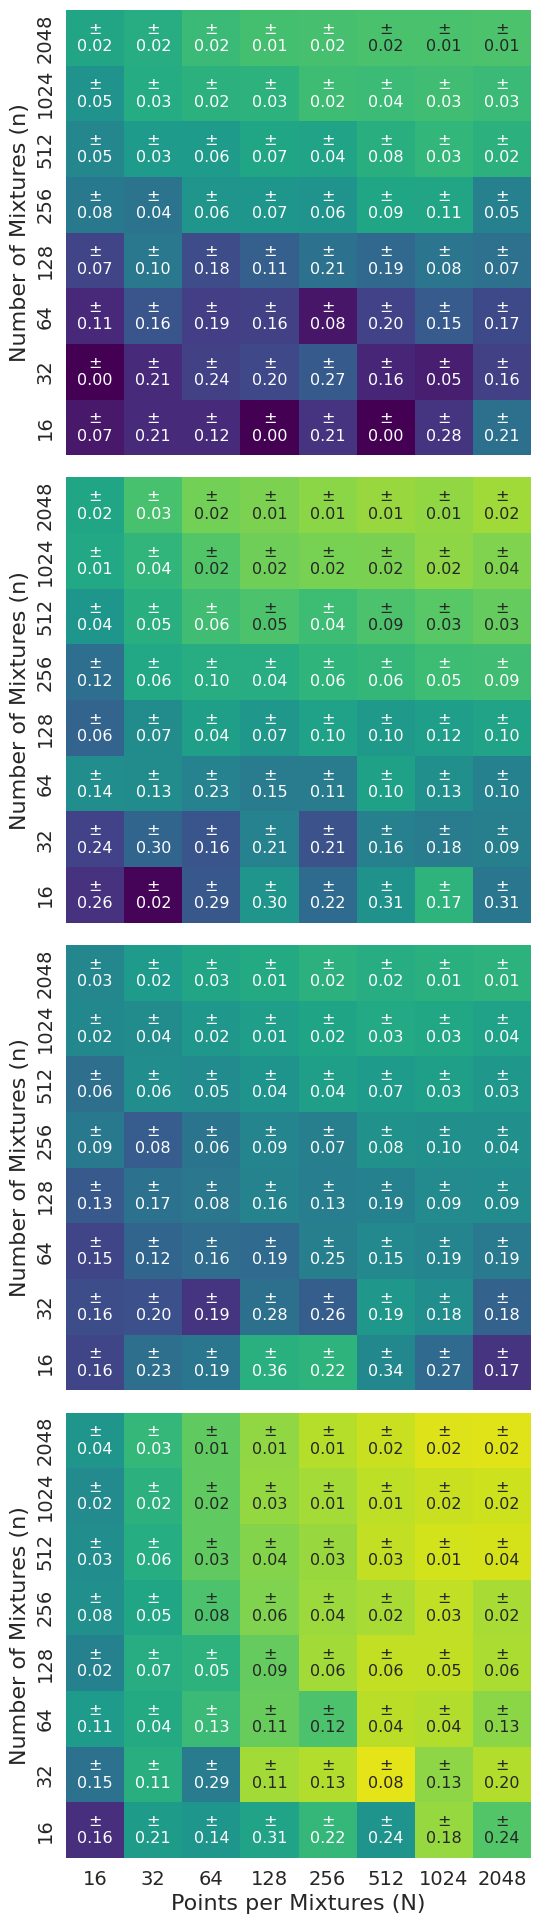

In [14]:
dpi = 300
plot_scores('sinkhorn', metric='evs', dpi=dpi)

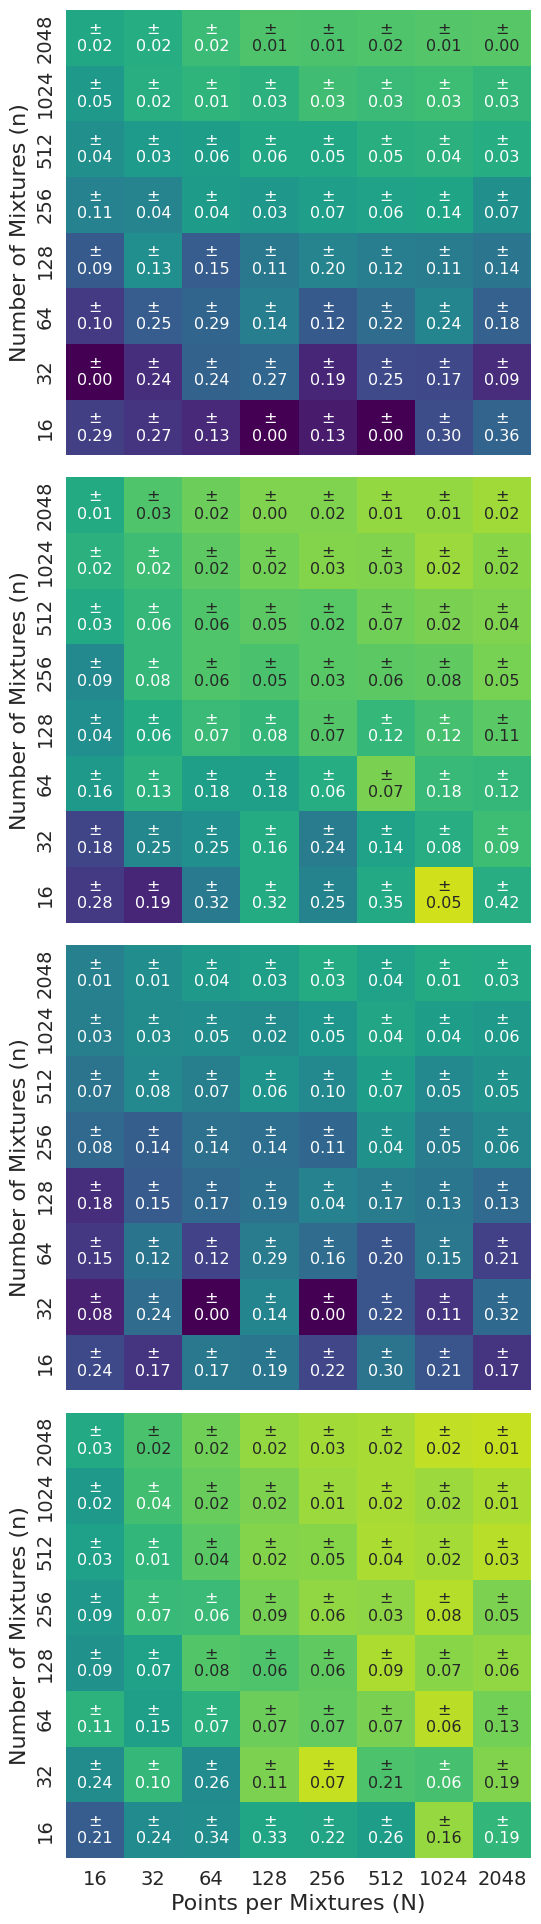

In [15]:
plot_scores('sliced', metric='evs', dpi=dpi)

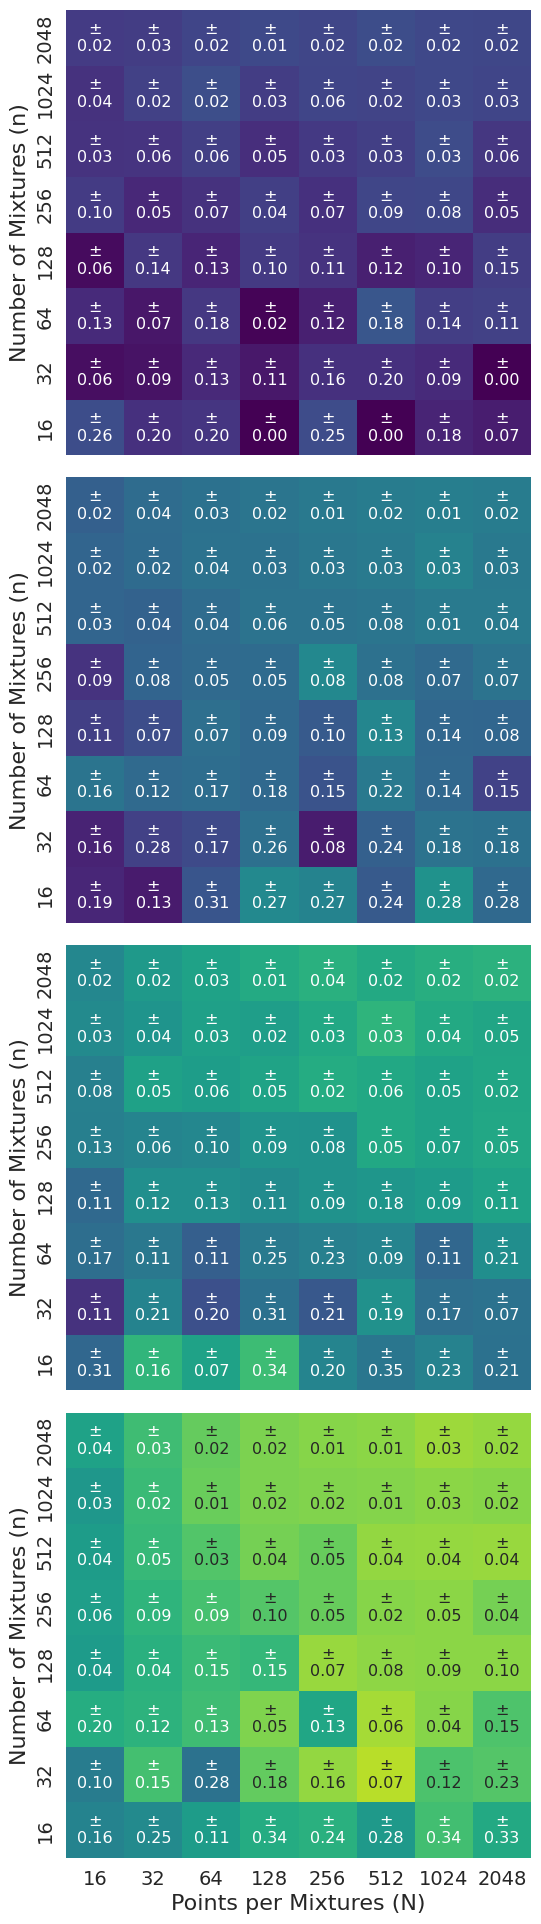

In [16]:
plot_scores('mean', metric='evs', dpi=dpi)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 24))  # Larger figsize for a bigger color bar
data = np.linspace(0.0, 0.8, 100).reshape(1, -1)
cax = ax.matshow(data, cmap='viridis', vmin=0.0, vmax=0.8)  # Set vmin and vmax
colorbar = plt.colorbar(cax, ax=ax, orientation='vertical')
# put label sligthly farther away
colorbar.set_label('Explained Variance Score (EVS)', fontsize=32, labelpad=20)
colorbar.ax.yaxis.set_tick_params(labelsize=32)  # Adjust the font size as needed
# save as legend.png
plt.savefig('legend.png', bbox_inches='tight', dpi=300)

<Axes: xlabel='T'>

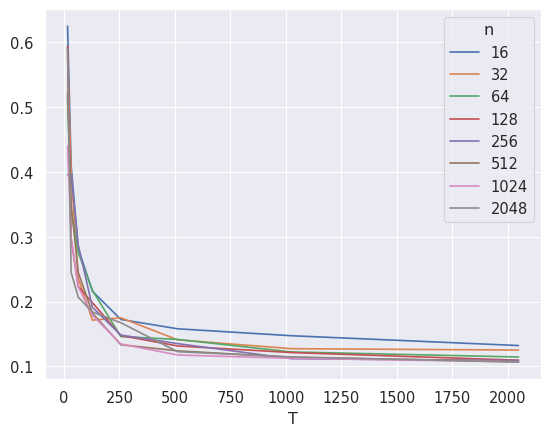

In [ ]:
df[(df['r'] == 2) & (df['C'] == 2)].groupby(['T', 'n']).mean(numeric_only=True).reset_index().pivot(index='T', columns='n', values='mse').plot()

In [ ]:
df[(df['r'] == 2) & (df['C'] == 2)].groupby(['T', 'n']).mean(numeric_only=True).reset_index().pivot(index='n', columns='T', values='mse').plot()